In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from accelerate import Accelerator
from einops import rearrange
import math
from typing import List, Optional, Tuple, Union
from torch.utils.data import Dataset, DataLoader
import h5py
from PIL import Image
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import InterpolationMode
import albumentations as A
import random
import matplotlib.pyplot as plt
import cv2
import gc
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import torch
import torch.nn as nn
import math
from einops import rearrange

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

def get_2d_sinusoidal_embedding(height, width, channels, device):
    assert channels % 4 == 0, "Channels must be divisible by 4 for sinusoidal embedding"
    pe = torch.zeros(1, channels, height, width, device=device)

    div_term = torch.exp(torch.arange(0, channels // 2, 2, device=device) * (-math.log(10000.0) / (channels // 2)))
    pos_w = torch.arange(width, device=device).unsqueeze(1)
    pos_h = torch.arange(height, device=device).unsqueeze(1)

    pe[0, 0::4, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).expand(-1, height, -1)
    pe[0, 1::4, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).expand(-1, height, -1)
    pe[0, 2::4, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).expand(-1, -1, width)
    pe[0, 3::4, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).expand(-1, -1, width)
    return pe

class DeepResNetEncoder(nn.Module):
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=7, stride=2, padding=3),  # (64, 448) -> (32, 224)
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )

        self.layer1 = self._make_layer(base_channels, base_channels, num_blocks=1, stride=2)     # (32, 224) -> (16, 112)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, num_blocks=1, stride=2) # (16, 112) -> (8, 56)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, num_blocks=1, stride=(1, 2)) # (8, 56) -> (8, 28)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, num_blocks=1, stride=(1, 2)) # (8, 28) -> (8, 14)

        self.out_channels = base_channels * 8

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)     # (64, 448) -> (32, 224)
        x = self.layer1(x)   # (32, 224) -> (16, 112)
        x = self.layer2(x)   # (16, 112) -> (8, 56)
        x = self.layer3(x)   # (8, 56) -> (8, 28)
        x = self.layer4(x)   # (8, 28) -> (8, 14)

        pe = get_2d_sinusoidal_embedding(x.shape[2], x.shape[3], x.shape[1], device=x.device)
        x = x + pe
        return rearrange(x, 'b c h w -> b (h w) c')  # Final shape: (B, 8*14, C)



In [3]:
if __name__ == "__main__":
    model = DeepResNetEncoder()
    input_tensor = torch.randn(2, 1, 96, 448)  # (B, C, H, W)
    output = model(input_tensor)
    print("Output shape:", output.shape)  # Should show shape like (2, 512, 2, 28)

Output shape: torch.Size([2, 168, 512])


In [4]:
char2idx = dict()
idx2char = dict()
pad_token = '<pad>'
start_token = '<s>'

char2idx[start_token] = len(char2idx)
char2idx[pad_token] = len(char2idx)

idx2char[len(idx2char)] = start_token
idx2char[len(idx2char)] = pad_token


In [5]:
for i in range(10):
    char2idx[str(i)] = len(char2idx)
    idx2char[len(idx2char)] = str(i)
    

In [6]:
end_token = '</s>'
idx2char[len(idx2char)] = end_token
char2idx[end_token] = len(char2idx)
print(char2idx, idx2char)

{'<s>': 0, '<pad>': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, '</s>': 12} {0: '<s>', 1: '<pad>', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: '</s>'}


In [7]:
def encode_values(s,char2idx=char2idx,max_len = 18):
    out = [char2idx['<s>']]
    for c in s:
        out.append(char2idx[c])
    out.append(char2idx['</s>'])
    if len(out)<max_len:
        pad_len = 18-len(out)
        out = out+[char2idx['<pad>']]*pad_len
    return out

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
    

In [8]:
s = '0135647964'
out = encode_values(s)
s_ = decode_values(out)
print(out,s_,len(s),len(out))

[0, 2, 3, 5, 7, 8, 6, 9, 11, 8, 6, 12, 1, 1, 1, 1, 1, 1] 0135647964 10 18


In [9]:
s = '25688730638264'
out = encode_values(s)
s_ = decode_values(out)
print(out,s_,len(s),len(out))

[0, 4, 7, 8, 10, 10, 9, 5, 2, 8, 5, 10, 4, 8, 6, 12, 1, 1] 25688730638264 14 18


In [10]:
s = '4685985739013568'
out = encode_values(s)
s_ = decode_values(out)
print(out,s_,len(s),len(out))

[0, 6, 8, 10, 7, 11, 10, 7, 9, 5, 11, 2, 3, 5, 7, 8, 10, 12] 4685985739013568 16 18


In [11]:
src = torch.rand(2,56,512)
trg = torch.randint(0, 5, (2,18))

In [12]:
print(src.size(),trg.size())

torch.Size([2, 56, 512]) torch.Size([2, 18])


In [13]:

class AttentionSelfOutput(nn.Module):
    def __init__(self, config, bias: Optional[bool] = True):
        super().__init__()
        self.dense = nn.Linear(
            config.hidden_size,
            config.hidden_size,
            bias=bias,
        )
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, hidden_states: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layernorm(hidden_states + input_tensor)
        return hidden_states


class DecoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.query = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.key = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.value = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times:
            print("WARNING: Flash Attention requires PyTorch >= 2.0")

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> Tuple[torch.Tensor, object]:
        q = self.query(hidden_state)
        k = self.key(hidden_state)
        v = self.value(hidden_state)
        # q,k,v = self.qkv(hidden_state).chunk(3, dim = -1) #b X l X d dim =-1 or 2
        # place holder for RoPe operation
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)

        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        if use_cache:
            cache = getattr(self, "cache", None)
            if cache is None:
                raise ValueError(
                    "you need to setup cache for every attention layer with model.setup_cache()"
                )
            k, v = cache.update(k, v, start_pos)

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask
        )
        out = rearrange(out, "b h l d -> b l (h d)")

        return self.out(out, hidden_state)


class EncoderDecoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.query = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.key = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.value = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = AttentionSelfOutput(config=config, bias=self.attention_bias)
        self.num_attention_heads = config.num_attention_heads

        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times:
            print("WARNING: Flash Attention requires PyTorch >= 2.0")

    def forward(
        self,
        hidden_state: torch.Tensor,
        encoder_hidden_state: torch.Tensor,
        encoder_attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> Tuple[torch.Tensor, object]:
        q = self.query(hidden_state)
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)

        if use_cache == False:  # train
            k = self.key(encoder_hidden_state)
            v = self.value(encoder_hidden_state)
            k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
            v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
            if freqs is not None:
                q, k = apply_rotary_pos_emb(q, k, freqs=freqs)

        if use_cache == True:  # kv-cache is enable
            cache = getattr(self, "cache", None)
            if cache is None:
                raise ValueError(
                    "use_cache is True please enable model._setup_cache() to use kv-cache"
                )
            if (
                cache is not None and len(cache) == 0
            ):  # first iteration witk kv-cache so store it it will be same for rest of the iteration
                k = self.key(encoder_hidden_state)
                v = self.value(encoder_hidden_state)
                k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
                v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
                if freqs is not None:

                    q, k = apply_rotary_pos_emb(q, k, freqs=freqs)
                k, v = self.cache.update(
                    k, v
                )  # store it will be same for all iteration

            elif cache is not None and len(cache) != 0:

                k, v = self.cache.get()  #

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=encoder_attention_mask
        )
        out = rearrange(out, "b h l d -> b l (h d)")

        return self.out(out, hidden_state)



class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        intermediate_size = getattr(config, "intermediate_size", None)
        self.intermediate_size = (
            int(multiplier) * config.hidden_size
            if intermediate_size is None
            else intermediate_size
        )

        self.intermediate = nn.Linear(config.hidden_size, self.intermediate_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
       
        self.act_fn = nn.GELU()
        self.out = nn.Linear(self.intermediate_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layernorm(output + input_tensor)
        return output
        
class AbsoluteEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.pos_embeddings = nn.Embedding(
            config.max_position_embeddings,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )
        self.max_size = config.max_position_embeddings

    def forward(self, size: int) -> torch.Tensor:
        if self.max_size < size:
            raise ValueError(
                f"The hidden size ({size }) is more than the config max_position_embeddings {self.max_size}"
            )
        return self.pos_embeddings(self.position_ids[:, :size])


In [14]:
class Seq2SeqDecoderLayer(nn.Module):
    def __init__(self, config, layer_idx: int = 0, attention_type: str = None) -> None:
        super().__init__()
        self.attention = DecoderAttention(config, layer_idx=layer_idx)
       
        self.cross_attention = EncoderDecoderAttention(config, layer_idx=layer_idx)
        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        encoder_hidden_state: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        out = self.attention(
            hidden_state=hidden_state,
            attention_mask=attention_mask,
            use_cache=use_cache,
            start_pos=start_pos,
        )
        out = self.cross_attention(
            hidden_state=out,
            encoder_hidden_state=encoder_hidden_state,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
        )

        out = self.feed_forward(out, hidden_state)
        return out


class LMHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.vocab = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.vocab.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.vocab(x)

        return x

In [15]:
from dataclasses import dataclass
@dataclass
class Seq2SeqOutput(object):
    logits: torch.Tensor
    
class Seq2SeqDecoderModel(nn.Module):
    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        self.position_embeddings = AbsoluteEncoding(
            config
        )
        
        self.all_layer = nn.ModuleList(
            [
                Seq2SeqDecoderLayer(config, layer_idx)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )

    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=0.02 / torch.sqrt(2 * len(self.all_layer))
            )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        encoder_hidden_state: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        _bsz, seqlen = input_ids.shape
        hidden_state = self.word_embeddings(input_ids)
        freqs = None
        if self.position_embeddings is not None:
            pos_info = pos_info = self.position_embeddings(start_pos + seqlen)[
                :, start_pos : start_pos + seqlen, :
            ].to(input_ids.device)
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, start_pos : start_pos + seqlen].to(
                input_ids.device
            )
        mask = None
        if seqlen > 1:
            mask = self.create_mask_for_decoder(
                input_ids=input_ids, attention_mask=attention_mask, start_pos=start_pos
            )
            mask = (1.0 - mask) * torch.finfo(
                hidden_state.dtype
            ).min  # invert it to to add directly to attention score

        for layer in self.all_layer:
            hidden_state = layer(
                hidden_state=hidden_state,
                attention_mask=mask,
                encoder_hidden_state=encoder_hidden_state,
                encoder_attention_mask=encoder_attention_mask,
                use_cache=use_cache,
                start_pos=start_pos,
            )
        return hidden_state

    def create_mask_for_decoder(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        start_pos: Optional[int] = 0,
    ) -> torch.Tensor:
        device = input_ids.device
        batch_size, seq_length = input_ids.shape
        if attention_mask is None:
            attention_mask = (
                torch.ones(seq_length + start_pos).repeat(batch_size, 1).to(device)
            )
        seq_ids = torch.arange(seq_length).to(device)
        causal_mask = (
            seq_ids[None, None, :].repeat(batch_size, seq_length, 1)
            <= seq_ids[None, :, None]
        )  # 1x1xl repeat bxlxl compare to 1xlx1

        causal_mask = causal_mask.to(attention_mask.dtype)

        if start_pos > 0:  # correct the attention mask  for kv-cache operation
            causal_mask = torch.cat(
                [
                    torch.ones(
                        (batch_size, seq_length, start_pos),
                        device=device,
                        dtype=causal_mask.dtype,
                    ),
                    causal_mask,
                ],
                axis=-1,
            )

        extended_attention_mask = (
            causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
        )  # this is mainly if batch contains <PAD> tokens. stop casual procees before <PAD>
        return extended_attention_mask

    @classmethod
    def from_config(cls, config) -> nn.Module:
        return cls(config)

In [16]:
from dataclasses import dataclass

@dataclass
class Config:
    hidden_size: int = 512
    num_attention_heads: int = 8
    max_position_embeddings: int = 18
    num_hidden_layers: int = 4
    vocab_size: int = len(idx2char)
    hidden_dropout_prob: float = 0.1
    initializer_range: float = 0.02
    intermediate_size: int = 1536
    layer_norm_eps: float = 1e-06
    hidden_act: str = "gelu"

In [17]:
config = Config()

In [18]:
model_ = Seq2SeqDecoderModel(config)

In [19]:
from dataclasses import dataclass
from typing import Any, Dict, Generator, List, Optional, Tuple
import torch


class DynamicCache:
    """
    A cache that grows dynamically as more tokens are generated. This is the default for generative models.

    It stores the Key and Value states as a list of tensors, one for each layer. The expected shape for each tensor is
    `[batch_size, num_heads, seq_len, head_dim]`.
    """

    def __init__(self, config) -> None:
        self.key_cache: torch.Tensor = None
        self.value_cache: torch.Tensor = None
        self._seen_tokens = False
        self.maxlen = config.max_position_embeddings

    def __len__(self) -> int:
        if self.key_cache is None:
            return 0
        """
        Support for backwards-compatible `past_key_value` length, e.g. `len(past_key_value)`. This value corresponds
        to the number of layers in the model.
        """
        return self.key_cache.shape[-2]

    def update(
        self, key_states: torch.Tensor, value_states: torch.Tensor, start_pos: int = 0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Updates the cache with the new `key_states` and `value_states` for the layer `layer_idx`.

        Parameters:
            key_states (`torch.Tensor`):
                The new key states to cache.
            value_states (`torch.Tensor`):
                The new value states to cache.
            layer_idx (`int`):
                The index of the layer to cache the states for.
            cache_kwargs (`Dict[str, Any]`, `optional`):
                Additional arguments for the cache subclass. No additional arguments are used in `DynamicCache`.

        Return:
            A tuple containing the updated key and value states.
        """

        # Update the cache first iteration
        if self.key_cache is None:
            self._seen_tokens = True
            self.key_cache = key_states.clone()
            self.value_cache = value_states.clone()
        else:
            self.key_cache = torch.cat([self.key_cache, key_states], dim=-2)
            self.value_cache = torch.cat([self.value_cache, value_states], dim=-2)

        return self.key_cache, self.value_cache

    def get(self) -> Tuple[torch.Tensor]:
        if self._seen_tokens:
            return self.key_cache, self.value_cache
        else:
            raise ValueError("there is no token available in kv-cache")

    def get_seq_length(self, layer_idx: Optional[int] = 0) -> int:
        """Returns the sequence length of the cached states. A layer index can be optionally passed."""
        if self.key_cache is None:
            return 0
        return self.key_cache.shape[-2]

    def get_max_length(self) -> Optional[int]:
        """Returns the maximum sequence length of the cached states. DynamicCache does not have a maximum length."""
        return None


class StaticCache:
    """
    A cache that is size fixed suitable for torch.compile

    It stores the Key and Value states as a list of tensors, one for each layer. The expected shape for each tensor is
    `[batch_size, num_heads, seq_len, head_dim]`.
    """

    def __init__(self, config) -> None:
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.heads = getattr(config, "num_key_value_heads", config.num_attention_heads)
        self.key_cache: torch.Tensor = torch.zeros(
            1,
            self.heads,
            config.max_position_embeddings,
            self.head_size,
        )
        self.value_cache: torch.Tensor = torch.zeros(
            1,
            self.heads,
            config.max_position_embeddings,
            self.head_size,
        )
        self._seen_tokens = False

    def update(
        self, k: torch.Tensor, v: torch.Tensor, start_pos: int = 0
    ) -> Tuple[torch.Tensor]:
        self._seen_tokens = True
        bsz, head, seqlen, _ = k.shape
        self.first_update_len = seqlen
        if seqlen > self.key_cache.size()[2]:
            raise ValueError(
                f"{k.shape} is more than init k_cache size {self.key_cache}"
            )

        assert bsz == 1, "Only support batch size 1"

        self.key_cache = self.key_cache.to(k)
        self.value_cache = self.value_cache.to(v)

        self.key_cache[:bsz, :, start_pos : start_pos + seqlen] = k
        self.value_cache[:bsz, :, start_pos : start_pos + seqlen] = v

        k = self.key_cache[:bsz, :, : start_pos + seqlen]
        v = self.value_cache[:bsz, :, : start_pos + seqlen]

        return k, v

    def get(self) -> Tuple[torch.Tensor]:
        if self._seen_tokens:
            k = self.key_cache[:, :, : self.first_update_len]
            v = self.value_cache[:, :, : self.first_update_len]

            return k, v
        else:
            raise ValueError("there is no token available in kv-cache")

    def __len__(self) -> int:
        if self._seen_tokens == False:
            return 0
        """
        Support for backwards-compatible `past_key_value` length, e.g. `len(past_key_value)`. This value corresponds
        to the number of layers in the model.
        """
        return self.key_cache.shape[2]

In [20]:
class EncoderDecoderModel(nn.Module):

    def __init__(
        self,
        encoder,
        decoder_config,
        decoder_pos_embedding_type: Optional[str] = "absolute",
        decoder_attention_type: str = None,
    ) -> None:
        super().__init__()
        self.encoder =  encoder
        self.decoder = Seq2SeqDecoderModel(
            config=decoder_config,
            pos_embedding_type=decoder_pos_embedding_type,
            attention_type=decoder_attention_type,
        )
        self.lm_head = LMHead(config=decoder_config)

    def forward(
        self,
        pixel_values: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        encoder_output: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = False,
        start_pos: Optional[int] = 0,
    ):
        if encoder_output is None:
            encoder_output = self.encoder(pixel_values)

        if encoder_attention_mask is None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_output.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            attention_mask = torch.ones(
                encoder_hidden_shape, device=encoder_output.device
            ).to(encoder_output.device)

        encoder_attention_mask = (
            attention_mask.unsqueeze(1).unsqueeze(2).type_as(encoder_output)
        )
        encoder_attention_mask = (1.0 - encoder_attention_mask) * torch.finfo(
            encoder_output.dtype
        ).min

        decoder_output = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_state=encoder_output,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
            start_pos=start_pos,
        )
        decoder_output = self.lm_head(decoder_output)
        return Seq2SeqOutput(logits=decoder_output)

    def get_decoder(self) -> Seq2SeqDecoderModel:
        return self.decoder

    def get_encoder_output(self, pixel_values: torch.Tensor) -> object:
        return self.encoder(pixel_values)

    def _setup_cache(self, config, cls: Optional[object] = StaticCache) -> None:
        for layer in self.decoder.all_layer:
            layer.attention.cache = cls(config)
            layer.cross_attention.cache = cls(config)

    def _clean_cache(self) -> None:
        for layer in self.decoder.all_layer:
            layer.attention.cache = None
            layer.cross_attention.cache = None

    @classmethod
    def from_config(
        cls,
        encoder,
        decoder_config,
        decoder_pos_embedding_type: Optional[str] = "absolute",
        decoder_attention_type: str = None,
    ) -> nn.Module:
        return cls(
            encoder,
            decoder_config,
            decoder_pos_embedding_type,
            decoder_attention_type,
        )

In [21]:
seq2seq = EncoderDecoderModel(DeepResNetEncoder(),config)

In [22]:
pixel = torch.rand(2,1,32,448)
decoder_input_ids = torch.randint(0,12,(2,18))
decoder_attention_mask = torch.ones(2,18)

In [23]:
out = seq2seq(pixel,decoder_input_ids,decoder_attention_mask)
out.logits.size()

torch.Size([2, 18, 13])

In [24]:
seq2seq

EncoderDecoderModel(
  (encoder): DeepResNetEncoder(
    (stem): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skip): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layer2): Sequential(
      (0): ResidualBlock(
        (conv

In [25]:
def model_size(model: nn.Module) -> float:
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

In [26]:
model_size(seq2seq)

75.97269821166992

In [27]:
def add_patch_lines(img, patch_size = (5,10), line_thickness=1):
    h, w = img.shape
    num_patches = random.randint(0, 10)  # Random number of patches
    for _ in range(num_patches):
        # Randomly choose the top-left corner of the patch
        x = random.randint(0, w - patch_size[1])
        y = random.randint(0, h - patch_size[0])
        img[y:y + patch_size[0], x:x + patch_size[1]] = 1  # Set the patch to white
        
        # # n_lines = random.randint(0,1)
        # # for  _ in range(n_lines):
        # y = random.randint(0,h-1)
        # img = cv2.line(img,(0,y),(w-1 ,y),1,1)

        # # n_lines = random.randint(0,1)
        # # for  _ in range(n_lines):
        # x = random.randint(0,h-1)
        # cv2.line(img,(x,0),(x ,h-1),1,1)
    return img

In [28]:
image_transform_A = A.Compose([A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3), p=0.8),
A.GaussianBlur(sigma_limit = (0.25,0.6),p=0.45),
A.Rotate(limit=(-2,2), p=1.0),
A.RandomBrightnessContrast(
    brightness_limit=(-0.2, 0.3),  
    contrast_limit=(-0.1, 0.1),   
    p=0.8
),
A.GaussNoise(std_range=(0.1, 0.25),mean_range = (-0.1,0.1),per_channel=True,p=0.8),
A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
A.ToTensorV2()])

            
image_transform = transforms.Compose(
                [
                    transforms.RandomAffine(
                        degrees=(-0.05, 0.05),
                        scale=(0.7, 1.1),
                        shear=(-30, 30),
                        interpolation=InterpolationMode.BILINEAR,
                        fill=0,
                    ),
                    transforms.GaussianBlur(3),
                    transforms.ToTensor(),
                ])

image_transform_val_ =  A.Compose(
                [
                   A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
                ])
image_transform_val = transforms.Compose(
                [
                    transforms.ToTensor(),
                ])
# Custom Dataset class
class NumpyDataset(Dataset):
    def __init__(self, file_path,image_transform,dtype = 'train'):
        self.dtype=dtype
        with h5py.File(file_path, "r") as f:
                self.X_train =  f[f"X_{dtype}"][:] #[Image.fromarray(_) for _ in f[f"X_{dtype}"][:]] #
                self.y_train = torch.IntTensor(f[f"y_{dtype}"])
        self.image_transform = image_transform

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        # Convert to tensor on access (optional: for memory efficiency)
        y = self.y_train[idx]
        c = ''
        for x in y:
            if x.item()!=-1:
                c+=str(x.item())
        out = encode_values(c)
        out = torch.tensor(out,dtype=torch.long)
        attn_mask = torch.ones_like(out)
        attn_mask = attn_mask.masked_fill(out==1,0)
        if self.dtype=='train':
            img = add_patch_lines(self.X_train[idx])
            img = self.image_transform(Image.fromarray(img))
            return  img, out,attn_mask
        else:
            img = self.image_transform(Image.fromarray(self.X_train[idx]))
            return  img, out,attn_mask
    
       
        #['image'] #image=self.X_train[idx]

In [29]:
file_path = '../input/ciphar-multidigit-mnist-latest/ml_16_o0.02_0.50_ntr75000_nv10000_nte20000_b1.h5'

train_dataset = NumpyDataset(file_path,image_transform,dtype = 'train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

val_dataset = NumpyDataset(file_path,image_transform_val,dtype = 'val')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)

/tmp/ipykernel_35/1919753361.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.y_train = torch.IntTensor(f[f"y_{dtype}"])


In [ ]:
fig = plt.figure(figsize=(18, 18))
for i in range(12):
    ax = fig.add_subplot(6, 2, i + 1)
    rand_idx = random.randint(0, len(train_dataset) - 1)
    image, y,_ = train_dataset[rand_idx]
    c = ''
    for x in y:
        if x.item() not in [0,1,12]: #<s>, <pad>,</s>
            c+=str(x.item()-2)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(c)

In [31]:
i=0
for img, tar,mask in train_loader:
    print(img.size(),tar.size(),mask.size())
    i+=1
    if i==5:
        break

torch.Size([16, 1, 96, 448]) torch.Size([16, 18]) torch.Size([16, 18])
torch.Size([16, 1, 96, 448]) torch.Size([16, 18]) torch.Size([16, 18])
torch.Size([16, 1, 96, 448]) torch.Size([16, 18]) torch.Size([16, 18])
torch.Size([16, 1, 96, 448]) torch.Size([16, 18]) torch.Size([16, 18])
torch.Size([16, 1, 96, 448]) torch.Size([16, 18]) torch.Size([16, 18])


In [32]:
def loss_fn(logits, labels):

    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)
    shift_logits = logits[..., :-1, :]
    shift_labels = labels[..., 1:]

    lm_loss = loss_fct(shift_logits.reshape(-1, 13), shift_labels.reshape(-1))
    return lm_loss
    
def validation(model, val_loader=val_loader):
    model.eval()
    all_loss = 0.0
    for step, (image,decoder_input_ids, decoder_attention_mask) in enumerate(val_loader):
            labels = torch.where(decoder_input_ids == 1, -100, decoder_input_ids)
            pixel_values = image.to(device)
            pred = seq2seq(
                pixel_values=pixel_values,
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=decoder_attention_mask.to(device),
            )
            loss = loss_fn(pred.logits, labels.to(device))
            all_loss += loss.detach().cpu().item()
    print("validation_loss = ", all_loss / len(val_loader))

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
from tqdm.notebook import tqdm
import numpy as np
def single_gpu(seq2seq):
    accumulation_steps = 1  # batch size 64 large dont need gradient accumulation
    lr = 5e-5
    EPOCHS = 1
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator = Accelerator(
        log_with="tensorboard",
        project_dir=".",
    )
    accelerator.init_trackers("Seq2Seq_project", config=Config)

    optimizer = torch.optim.AdamW(seq2seq.parameters(), lr = lr)
    

    seq2seq.to(device)

    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    t_step = 1
    k = 0
    for epoch in range(EPOCHS):
        seq2seq.train()
        avg_loss = 0.0
        loss_list = []
        running_loss = 0.0
        for step, (image,decoder_input_ids, decoder_attention_mask) in enumerate(train_loader):
            train_bar.update(1)
            labels = torch.where(decoder_input_ids == 1, -100, decoder_input_ids)
            pixel_values = image.to(device)
            optimizer.zero_grad()
            pred = seq2seq(
                pixel_values=pixel_values,
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=decoder_attention_mask.to(device),
            )
            loss = loss_fn(pred.logits, labels.to(device))
            loss.backward()
            optimizer.step()
           

            accelerator.log({"training_loss_step": loss}, step=t_step)

            train_bar.set_description(
                f'epoch: {epoch+1} step: {t_step} loss: {"%.4f" % loss}'
            )
            t_step += 1
            loss_list.append(loss.detach().cpu().item())
        #         scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"training_loss_epoch": avg_loss}, step=epoch + 1)
        print(f'Epoch: {epoch+1} loss: {"%.4f" % avg_loss }')
        validation(seq2seq)
    accelerator.end_training()
    PATH = f"image_language_seq2seq_{epoch}.pth"
    torch.save(seq2seq.state_dict(), PATH)
    return seq2seq


In [34]:
seq2seq = single_gpu(seq2seq)

2025-06-08 13:53:21.703008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749390801.898727      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749390801.954818      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/4688 [00:00<?, ?it/s]

Epoch: 1 loss: 1.7723
validation_loss =  0.47818114891052244


In [35]:
del train_loader,train_dataset, val_dataset, val_loader
gc.collect()

243

In [36]:
file_path = '../input/ciphar-multidigit-mnist-latest/ml_16_o0.02_0.50_ntr75000_nv10000_nte20000_b2.h5'

train_dataset = NumpyDataset(file_path,image_transform,dtype = 'train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

val_dataset = NumpyDataset(file_path,image_transform_val,dtype = 'val')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
seq2seq = single_gpu(seq2seq)

In [37]:
seq2seq.eval()

EncoderDecoderModel(
  (encoder): DeepResNetEncoder(
    (stem): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skip): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layer2): Sequential(
      (0): ResidualBlock(
        (conv

In [38]:
def generate(
    model: nn.Module,
    encoder_output: torch.Tensor,
    encoder_attention_mask: torch.Tensor,
    decoder_start: torch.Tensor,
    max_new_tokens=18,
    temperature=1.0,
    do_sample=False,
    top_k=1,
    use_cache=False,
) -> torch.Tensor:
    """

    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete

    the sequence max_new_tokens times, feeding the predictions back into the model each time.

    Most likely you'll want to make sure to be in model.eval() mode of operation for this.

    """
    idx = decoder_start

    idx_next = idx

    index = 0

    #     for cur_pos in range(min_promp, total_len)

    for _ in range(max_new_tokens):

        if use_cache:
            with torch.no_grad():
                logits = model(
                    encoder_output=encoder_output,
                    decoder_input_ids=idx_next,
                    use_cache=use_cache,
                    start_pos=index,
                ).logits
            logits = logits[:, -1] / temperature
        else:
            with torch.no_grad():
                logits = model(
                    encoder_output=encoder_output,
                    decoder_input_ids=idx,
                    #                     use_cache=use_cache,
                ).logits
            if index == 0:  # start token
                logits = logits[:, -1] / temperature
            else:
                logits = logits[:, -1, :] / temperature

        probs = torch.nn.functional.softmax(logits, dim=-1)

        # either sample from the distribution or take the most likely element

        if do_sample:

            idx_next = torch.multinomial(probs, num_samples=1)

        else:

            _, idx_next = torch.topk(probs, k=1, dim=-1)

        # append sampled index to the running sequence and continue

        idx = torch.cat((idx, idx_next), dim=1)

        index = idx.size()[1] - 1  # model already have idx-1 kv-cache stored

    return idx

Text(0.5, 1.0, '568793100310995->508793100310895')

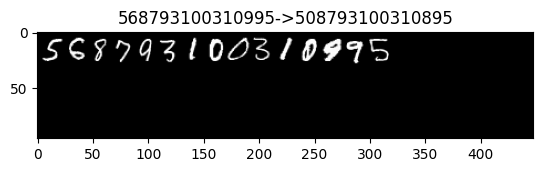

In [39]:
image, y,_ = val_dataset[0]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->'+mout)

Text(0.5, 1.0, '8672748663587->pred =8672198663587')

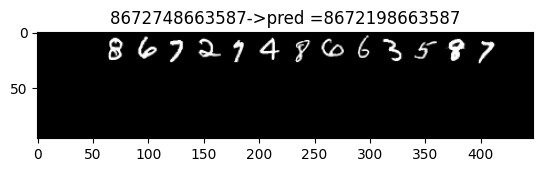

In [40]:
image, y,_ = val_dataset[1]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '13453086-> pred = 13453086')

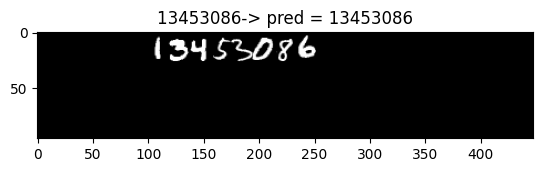

In [41]:
image, y,_ = val_dataset[2]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'-> pred = '+mout)

Text(0.5, 1.0, '1771314926->pred =1971314966')

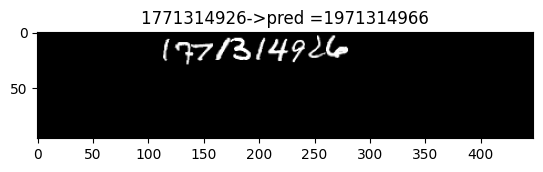

In [42]:
image, y,_ = val_dataset[3]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '7499404346->pred =7499407546')

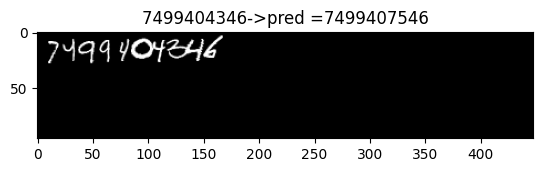

In [43]:
image, y,_ = val_dataset[4]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '177414->pred =177414')

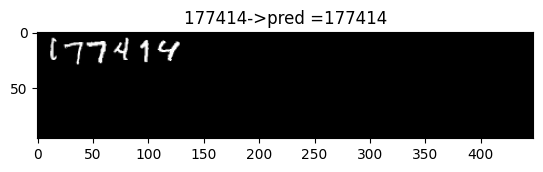

In [44]:
image, y,_ = val_dataset[5]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '673525508832->pred =673555508830')

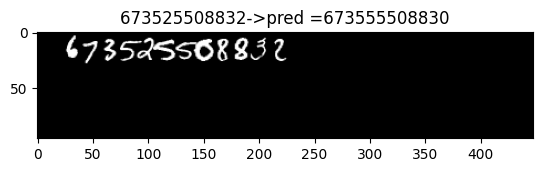

In [45]:
image, y,_ = val_dataset[6]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '16936429357->pred =16926429357')

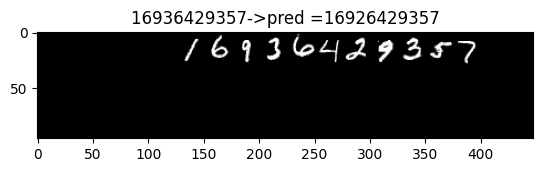

In [46]:
image, y,_ = val_dataset[7]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '59493954->pred =54493954')

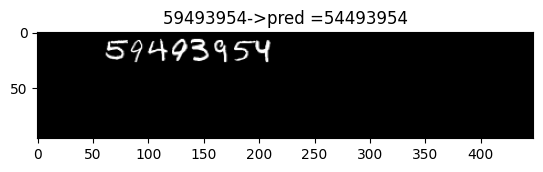

In [47]:
image, y,_ = val_dataset[8]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '192379030646660->pred =192279030466660')

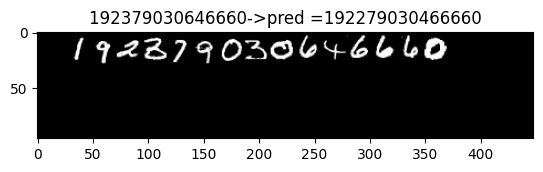

In [48]:
image, y,_ = val_dataset[9]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)

Text(0.5, 1.0, '5651711->pred =5651417')

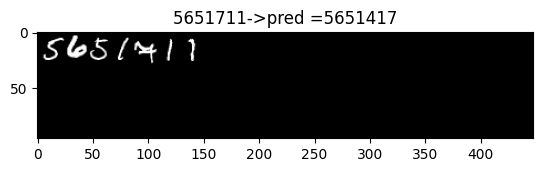

In [49]:
image, y,_ = val_dataset[10]
encoder_output = seq2seq.encoder(image.unsqueeze(0).to(device))
idx = torch.tensor([0]).unsqueeze(0).to(device)
out = generate(
    model=seq2seq,
    encoder_attention_mask=None,
    encoder_output=encoder_output,
    decoder_start=idx,
)
c = ''
for x in y:
    if x.item() not in [0,1,12]: #<s>, <pad>,</s>
        c+=str(x.item()-2)

def decode_values(s,idx2char=idx2char):
    out = ''
    for c in s[1:]:
        if c in [1,12]:
            break
        out+=idx2char[c]
    return out
    
mout = decode_values(out[0].tolist())
plt.imshow(image.squeeze(), cmap="gray")
plt.title(c+'->pred ='+mout)